# tensorflow pistachio


## Links
  - [notes on training/validation loss](https://siddiqueabusaleh.medium.com/why-my-training-loss-is-higher-than-validation-loss-is-the-reported-loss-even-accurate-8843e14a0756)
  - [initialisation values](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)
  - [shap feature importance](https://shap.readthedocs.io/en/latest/tabular_examples.html#neural-networks)

In [1]:
import tensorflow as tf
print(tf.__version__)

2024-11-29 03:00:44.363023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1


## arff to csv





In [2]:
import pandas as pd 
from scipy.io import arff
import os 
label_mapping = {'Kirmizi_Pistachio': 0, 'Siit_Pistachio': 1}

def load_arff_file(input_arff: str) -> pd.DataFrame:
    """convert arff file to parquet"""
    if not os.path.exists(input_arff):
        raise ValueError(f"input file '{input_arff}' does not exist")
    print(f'loading arff file {input_arff}')
    data, meta = arff.loadarff(input_arff)
    print(f"arff metadata: {meta}")
    df = pd.DataFrame(data)
    df['Class'] = df['Class'].astype(str).map(label_mapping)
    
    return df
##################

arff_filename = './data/Pistachio_16_Features_Dataset.arff'
csv_filename = './data/pistachio_16.csv'
if not os.path.exists(csv_filename):
    df = load_arff_file(arff_filename)
    df.head()
    df.to_csv(csv_filename, index=False, header=True)
    print(f'wrote file to {csv_filename}')
else:
    print(f'{csv_filename} exists')


./data/pistachio_16.csv exists


In [3]:
## Parameters

In [4]:


# dataset
BATCH_SIZE = 32 
PREFETCH = tf.data.AUTOTUNE
SEED=37

# model parameters
UNITS = 5
LAYER_1_L1 = 0
LAYER_1_L2 = 3e-3
LAYER_2_L1 = 0
LAYER_2_L2 = 3e-3

#model fitting
EPOCHS = 100
LEARNING_RATE = 0.0005 # initial learning rate
LR_PLATEAU_FACTOR = 0.8
LR_PLATEAU_PATIENCE = 5
LR_DECAY_RATE = 0.8
MIN_LEARNING_RATE = 1.0e-5
EARLY_STOPPING_PATIENCE = 20


# mlflow
MLFLOW_URI = uri="http://pistachio_mlflow:5000"
MLFLOW_EXPERIMENT = "pistachio_tf_20241128"
MLFLOW_RUN_DESCRIPTION = 'simple two layer network, some regularisation'
MLFLOW_TAGS = {'architecture': f'two layers, {UNITS} units, no regularisation'}




In [5]:
# clear state
# useful for rerunning things
tf.keras.backend.clear_session()

## dataset


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


def split_csv_data(infilename: str, train_filename: str, test_filename:str, test_fraction: float):
    df = pd.read_csv(infilename, header=0)
    columns = df.columns
    df['split_var'] = np.random.uniform(size=len(df))
    train_df = df.loc[df.split_var <= test_fraction][columns]
    test_df = df.loc[df.split_var > test_fraction][columns]
    train_df.to_csv(train_filename, index=False, header=True)
    test_df.to_csv(test_filename, index=False, header=True)
    print(f'wrote {len(train_df)} records to {train_filename}')
    print(f'wrote {len(test_df)} records to {test_filename}')
##########################################################

def df_to_dataset(df: pd.DataFrame, target_column: str):
    feature_df = df.copy()
    target = feature_df.pop(target_column)
    dataset = tf.data.Dataset.from_tensor_slices((dict(feature_df), target))
    dataset = dataset.shuffle(buffer_size=len(feature_df))\
        .batch(BATCH_SIZE, drop_remainder=True)\
        .prefetch(PREFETCH)
    return dataset
##########################################################

def split_data_to_frames(infilename: str, test_fraction: float=0.2, val_fraction: float=0.25, seed:int=43, stratify=None):
    """ load csv as dataframe, split"""

    df = pd.read_csv(infilename)
    train_val_df, test_df = train_test_split(df, test_size=test_fraction, random_state=seed, stratify=df[stratify])
    train_df, val_df = train_test_split(train_val_df, test_size=val_fraction, random_state=seed+1, stratify=train_val_df[stratify])
    return train_df, val_df, test_df
##########################################################

train_df, valid_df, test_df = split_data_to_frames(csv_filename, stratify='Class', seed=SEED)

for setname, df in zip(['train','validation','test'],[train_df, valid_df, test_df]):
    print(setname)
    print(f'df shape = {df.shape}')
    agged = df.groupby('Class').agg({'AREA':'count'}).reset_index()
    print(agged)


feature_columns = list(train_df.columns)
feature_columns.remove('Class')
feature_columns

# train_ds, valid_ds, test_ds = get_datasets(csv_filename, 'Class')

#     train_ds = df_to_dataset(train_df, target_column)
#     val_ds = df_to_dataset(val_df, target_column)
#     test_ds = df_to_dataset(test_df, target_column)


    
# train_filename = './data/pistachio_train.csv'
# test_filename = './data/pistachio_test.csv'

# if not (os.path.exists(train_filename) and os.path.exists(test_filename)):
#     split_csv_data(csv_filename, train_filename, test_filename, 0.2)
# else:
#     print(f'{train_filename} and {test_filename} exist')






train
df shape = (1288, 17)
   Class  AREA
0      0   738
1      1   550
validation
df shape = (430, 17)
   Class  AREA
0      0   247
1      1   183
test
df shape = (430, 17)
   Class  AREA
0      0   247
1      1   183


['AREA',
 'PERIMETER',
 'MAJOR_AXIS',
 'MINOR_AXIS',
 'ECCENTRICITY',
 'EQDIASQ',
 'SOLIDITY',
 'CONVEX_AREA',
 'EXTENT',
 'ASPECT_RATIO',
 'ROUNDNESS',
 'COMPACTNESS',
 'SHAPEFACTOR_1',
 'SHAPEFACTOR_2',
 'SHAPEFACTOR_3',
 'SHAPEFACTOR_4']

In [7]:
train_ds = df_to_dataset(train_df,'Class')
valid_ds = df_to_dataset(valid_df,'Class')
test_ds = df_to_dataset(test_df,'Class')

In [8]:
def get_dataset_class_proportions(the_dataset):
    def count_class(counts, batch, num_classes=2):
        labels = batch[1] # class is second element of tuple
        for i in range(num_classes):
            cc = tf.cast(labels == i, tf.int32)
            counts[str(i)] += tf.reduce_sum(cc)
        return counts
    initial_state = {'0':0, '1':0}
    proportions = {k: v.numpy() for k,v in the_dataset.reduce(reduce_func=count_class, initial_state=initial_state).items()}
    total = sum(proportions.values())
    proportions.update({f'proportion_{k}': v/total for k,v in proportions.items()})
    
    return proportions
    

print(f'train: {get_dataset_class_proportions(train_ds)}')
print(f'valid: {get_dataset_class_proportions(valid_ds)}')
print(f'test: {get_dataset_class_proportions(test_ds)}')

   


train: {'0': 734, '1': 546, 'proportion_0': 0.5734375, 'proportion_1': 0.4265625}
valid: {'0': 240, '1': 176, 'proportion_0': 0.5769230769230769, 'proportion_1': 0.4230769230769231}
test: {'0': 241, '1': 175, 'proportion_0': 0.5793269230769231, 'proportion_1': 0.4206730769230769}


In [9]:
# def map_func(features, labels):
#     return tf.transpose(tf.stack([features[k] for k in features])), tf.reshape(labels,[-1,1])

# # use dataset.map to concatenate feature dictionary into tensor
# pistachio_train_batches = tf.data.experimental.make_csv_dataset(
#     train_filename, batch_size=4,
#     num_epochs=1,
#     label_name="Class").map(map_func)
# pistachio_test_batches = tf.data.experimental.make_csv_dataset(
#     test_filename, batch_size=4,
#     num_epochs=1,
#     label_name="Class").map(map_func)

In [10]:
batch = 0
# for feature_batch, label_batch in pistachio_train_batches.take(2):
for feature_batch, label_batch in train_ds.take(2):
    # print(f'{batch}, {label_batch.shape}')
    # cat_batch = tf.stack([feature_batch['AREA'],feature_batch['PERIMETER']],axis=1)
    # cat_batch = tf.stack([feature_batch[k] for k in feature_batch],axis=1)

    # batch += 1
    
    print("'label': {}".format(label_batch))
    # print(cat_batch)
    print(f"features batch shape: {feature_batch['AREA'].shape}")
    # print(feature_batch.shape)
    

'label': [1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0]
features batch shape: (32,)
'label': [1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
features batch shape: (32,)


2024-11-29 03:00:47.109757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Functional API
try this instead, dataset is weird

In [11]:
train_ds.cardinality().numpy()


40

In [12]:
from typing import List, Dict
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Normalization
from tensorflow.keras import Model
from tensorflow.keras.metrics import Accuracy, AUC, Recall, Precision

def get_pistachio_model(feature_columns: List[str], train_dataset: tf.data.Dataset, units: int=10):
    """build a pistachio model using functional api"""
    def _get_feature_normalizers():
        """initialise and adapt the feature normalisers"""
        print(f'preprocessing - initialising normalisers')
        normalizers = {}
        for feature in feature_columns:
            normaliser =  Normalization(axis=None, name=f'normalizer_{feature}')
            just_this_feature_ds = train_dataset.map(lambda x,y: x[feature])
            normaliser.adapt(just_this_feature_ds)
            normalizers[feature] = normaliser
        return normalizers
        
    def _build_model(normalizers: Dict):
        normalized_inputs = []
        raw_inputs = []
        for feature in feature_columns:
            feature_input = tf.keras.Input(shape=(1,), name=feature)
            raw_inputs.append(feature_input)
            normalized_input = normalizers[feature](feature_input)
            normalized_inputs.append(normalized_input)

        input_layer = tf.keras.layers.concatenate(normalized_inputs)

        # densely connected layers
        d1 = Dense(
            units,
            activation='relu',
            name='dense_1',
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=LAYER_1_L1, l2=LAYER_1_L2))
        
        d2 = Dense(
            units,
            activation='relu',
            name='dense_2',
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=LAYER_2_L1, l2=LAYER_2_L2))
        

        # output layer
        output_layer = Dense(1, activation='sigmoid', name='predicted_probability')
        # http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines

        # define graph
        x = d1(input_layer)
        x = d2(x)
        output_probability = output_layer(x)
        
        model = tf.keras.Model(raw_inputs, output_probability)
        return model
    normalizers = _get_feature_normalizers()
    model = _build_model(normalizers)
    return model
 

In [13]:
import os
import shutil



logdir = './pistachio_model_logs'
if os.path.exists(logdir):
    shutil.rmtree(logdir)
os.makedirs(logdir, exist_ok=True)
checkpoint_dir = './pistachio_model_checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

metrics = {
    'predicted_probability': [
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.BinaryAccuracy()]
}

callbacks = [
    tf.keras.callbacks.TensorBoard(logdir, update_freq='batch'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=LR_PLATEAU_FACTOR, patience=LR_PLATEAU_PATIENCE, min_lr=MIN_LEARNING_RATE),
    # tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: max(lr*LR_DECAY_RATE, MIN_LEARNING_RATE))
    tf.keras.callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE)
    # mlflow included later - based off mlflow runid
    # checkpointing included later - uses mlflow runid
]

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# build the model
model = get_pistachio_model(feature_columns, train_ds, units=UNITS)

# compile the model
model.compile(
    optimizer=optimizer,
    loss={'predicted_probability': tf.keras.losses.BinaryCrossentropy(from_logits=False)},
    metrics=metrics)

preprocessing - initialising normalisers


2024-11-29 03:00:47.458478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-29 03:00:47.497565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-29 03:00:47.534983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-29 03:00:47.573589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-29 03:00:47.619572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-29 03:00:47.663240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-29 03:00:47.710856: W tensorflow/core/framework/local_rendezvous.cc:404] L

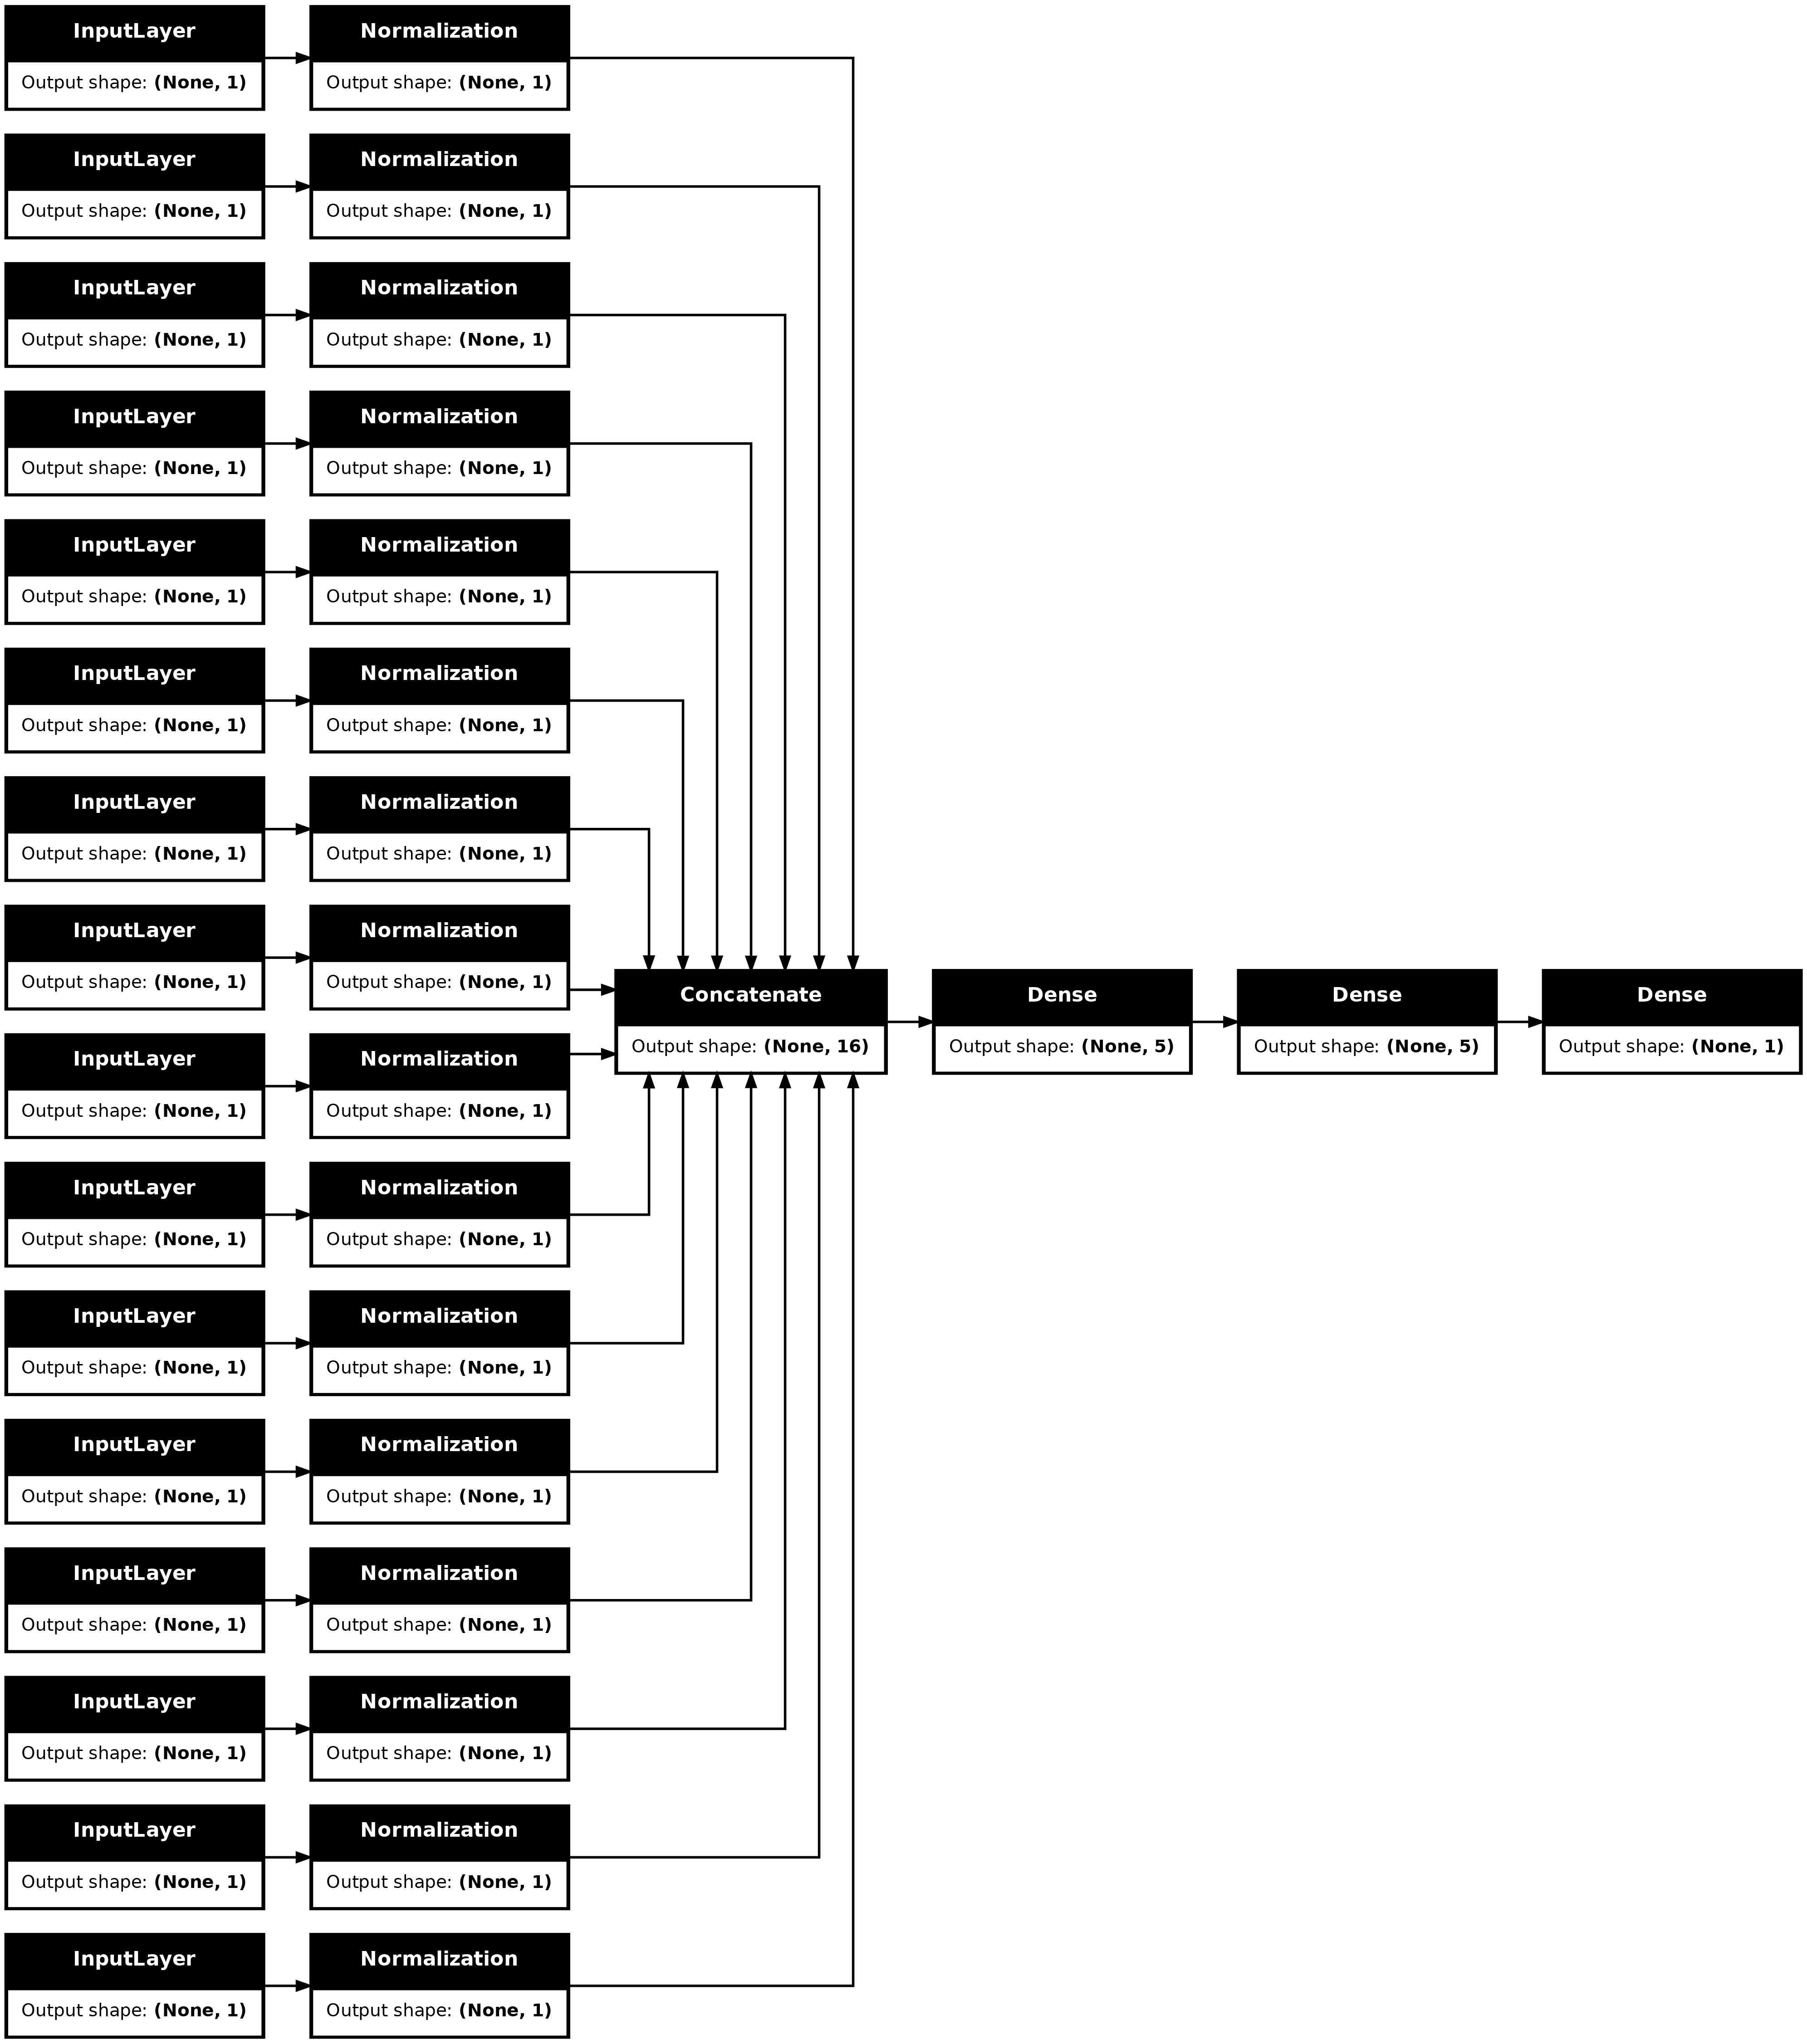

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ AREA (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PERIMETER           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MAJOR_AXIS          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MINOR_AXIS          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ECCENTRICITY        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EQDIASQ             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SOLIDITY            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CONVEX_AREA         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EXTENT (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ASPECT_RATIO        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ROUNDNESS           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ COMPACTNESS         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SHAPEFACTOR_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SHAPEFACTOR_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SHAPEFACTOR_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SHAPEFACTOR_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalizer_AREA     │ (None, 1)         │          3 │ AREA[0][0]        │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 169 (740.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 48 (256.00 B)

## mlflow - setup logging

In [16]:
params = {
    'BATCH_SIZE': BATCH_SIZE,
    'PREFETCH': PREFETCH,
    'SEED': SEED,
    'UNITS': UNITS,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'LR_PLATEAU_FACTOR': LR_PLATEAU_FACTOR,
    'LR_DECAY_RATE': LR_DECAY_RATE,
    'MIN_LEARNING_RATE': MIN_LEARNING_RATE,
    'FEATURE_COLUMNS': feature_columns,
    'LAYER_1_L1':LAYER_1_L1,
    'LAYER_1_L2':LAYER_1_L2,
    'LAYER_2_L1':LAYER_2_L1,
    'LAYER_2_L2':LAYER_2_L2
}
for k,v in params.items():
    print(f'{k}: {v}')

BATCH_SIZE: 32
PREFETCH: -1
SEED: 37
UNITS: 5
EPOCHS: 100
LEARNING_RATE: 0.0005
LR_PLATEAU_FACTOR: 0.8
LR_DECAY_RATE: 0.8
MIN_LEARNING_RATE: 1e-05
FEATURE_COLUMNS: ['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY', 'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO', 'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2', 'SHAPEFACTOR_3', 'SHAPEFACTOR_4']
LAYER_1_L1: 0
LAYER_1_L2: 0.003
LAYER_2_L1: 0
LAYER_2_L2: 0.003


In [17]:
import mlflow

mlflow.set_tracking_uri(uri=MLFLOW_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT)
# don't autolog
# mlflow.tensorflow.autolog()

# if passing an existing run_id to mlflow.start_run, it treats it as resuming that run (update/change parameters, metrics)



<Experiment: artifact_location='/mlflow/artifacts/312072479125166365', creation_time=1732847538920, experiment_id='312072479125166365', last_update_time=1732847538920, lifecycle_stage='active', name='pistachio_tf_20241128', tags={}>

In [18]:
with mlflow.start_run(tags=MLFLOW_TAGS, description=MLFLOW_RUN_DESCRIPTION) as mlflow_run:
    # append mlflow callback to callbacks
    run_name = mlflow_run.info.run_name
    run_id = mlflow_run.info.run_id
    callbacks.append(mlflow.keras.MlflowCallback(mlflow_run))
    # append model checkpoint to callbacks
    checkpoint_path = os.path.join(checkpoint_dir,f'model_{mlflow_run.info.run_name}.model.keras')
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_auc',
        save_best_only=True))       
    
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        validation_data=valid_ds)

    mlflow.log_params(params)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - auc: 0.3274 - binary_accuracy: 0.4363 - loss: 0.8526 - precision: 0.4379 - recall: 0.9786 - val_auc: 0.3996 - val_binary_accuracy: 0.4327 - val_loss: 0.8060 - val_precision: 0.4314 - val_recall: 0.9778 - learning_rate: 5.0000e-04
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.3702 - binary_accuracy: 0.4203 - loss: 0.8093 - precision: 0.4182 - recall: 0.9655 - val_auc: 0.4889 - val_binary_accuracy: 0.4423 - val_loss: 0.7645 - val_precision: 0.4328 - val_recall: 0.9775 - learning_rate: 5.0000e-04
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.5190 - binary_accuracy: 0.4524 - loss: 0.7502 - precision: 0.4429 - recall: 0.9262 - val_auc: 0.5857 - val_binary_accuracy: 0.4736 - val_loss: 0.7337 - val_precision: 0.4417 - val_recall: 0.9261 - learning_rate: 5.0000e-04
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.6299 - binary_accuracy: 0.4991 - loss: 0.7245 - precision: 0.4469 - recall: 0.9126 - val_a

In [19]:
history_df = pd.DataFrame(history.history)
history_df.columns

Index(['auc', 'binary_accuracy', 'loss', 'precision', 'recall', 'val_auc',
       'val_binary_accuracy', 'val_loss', 'val_precision', 'val_recall',
       'learning_rate'],
      dtype='object')

In [20]:
history_df.tail()

,auc,binary_accuracy,loss,precision,recall,val_auc,val_binary_accuracy,val_loss,val_precision,val_recall,learning_rate
80,0.946245,0.879687,0.319923,0.871698,0.843066,0.934209,0.853365,0.352633,0.836257,0.812500,0.000105
81,0.947064,0.882031,0.317465,0.873346,0.846154,0.935785,0.853365,0.348410,0.837209,0.813559,0.000105
82,0.946152,0.879687,0.319876,0.870722,0.841912,0.935014,0.853365,0.349956,0.836257,0.812500,0.000105
83,0.947587,0.881250,0.316174,0.871456,0.845872,0.935688,0.853365,0.349375,0.842105,0.808989,0.000105
84,0.946428,0.879687,0.319651,0.872180,0.843636,0.940341,0.855769,0.335402,0.837209,0.818182,0.000105


In [21]:
from typing import List, Dict, Callable, Tuple

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric(history_df: pd.DataFrame, metric_name:str):
    '''plot metric vs epoch'''
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # train data value 
    if metric_name == 'learning_rate':
        ax.plot(history_df.index, history_df[metric_name], color=sns.xkcd_rgb['merlot'], label=metric_name)
    else:    
        ax.plot(history_df.index, history_df[metric_name], color=sns.xkcd_rgb['merlot'], label=f'train_{metric_name}')
        ax.plot(history_df.index, history_df[f'val_{metric_name}'], color=sns.xkcd_rgb['blurple'], label=f'val_{metric_name}')
    ax.legend()
    ax.set_title(f'{metric_name} vs epoch')
    return fig, ax

sns.set()
    

./plots/delightful-vole-839/learning_rate_vs_epoch.png
./plots/delightful-vole-839/auc_vs_epoch.png
./plots/delightful-vole-839/loss_vs_epoch.png
./plots/delightful-vole-839/binary_accuracy_vs_epoch.png
./plots/delightful-vole-839/recall_vs_epoch.png
./plots/delightful-vole-839/precision_vs_epoch.png


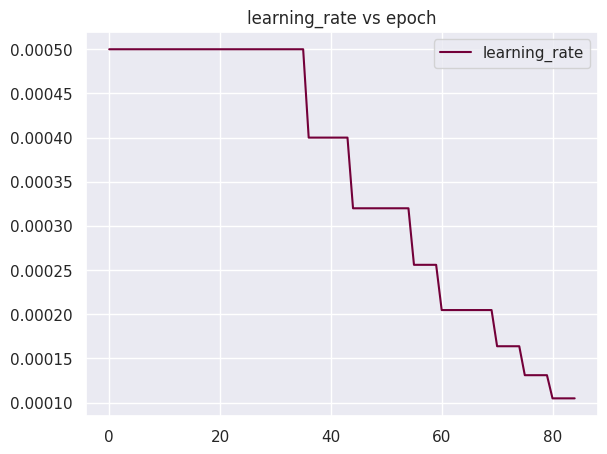

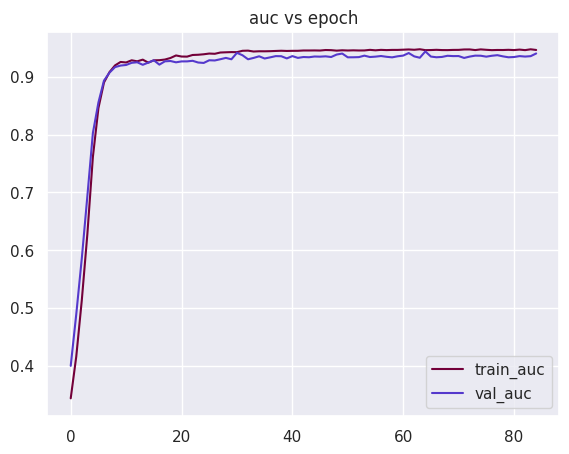

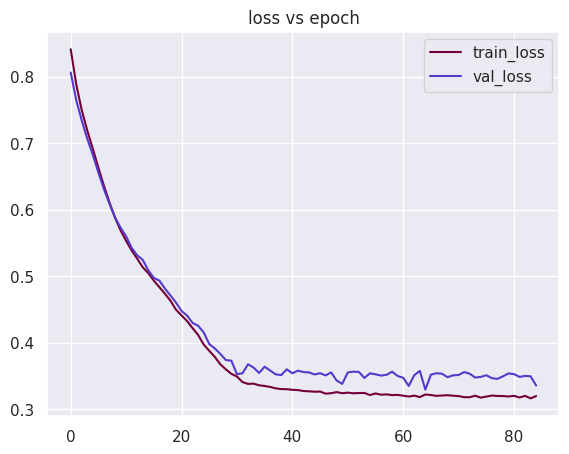

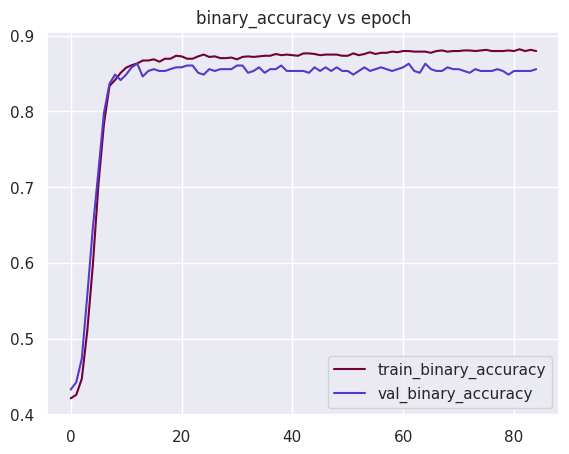

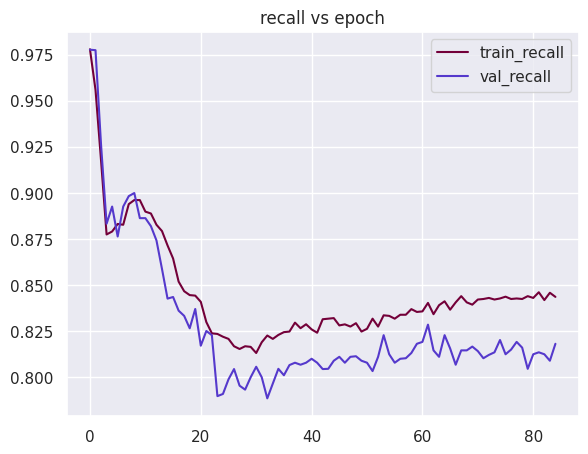

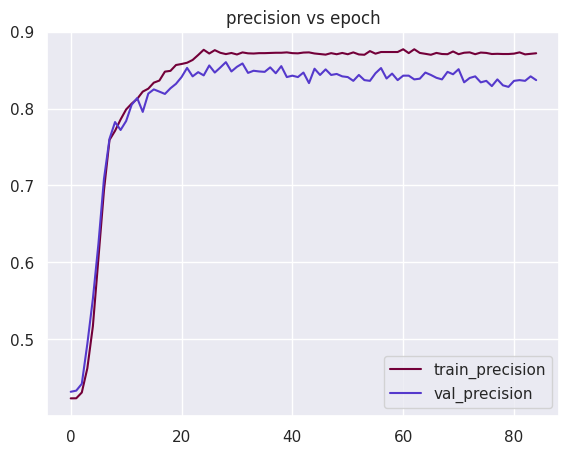

In [22]:

plot_dir = f'./plots/{run_name}/'
os.makedirs(plot_dir, exist_ok=True)
metrics_to_plot = [
    'learning_rate',
    'auc',
    'loss',
    'binary_accuracy',
    'recall',
    'precision']

metric_plots = {}
for mm in metrics_to_plot:
    metric_plots[mm] = plot_metric(history_df, mm);
    fig_path = os.path.join(plot_dir, f'{mm}_vs_epoch.png');
    print(fig_path)
    metric_plots[mm][0].savefig(fig_path);
                                 

    

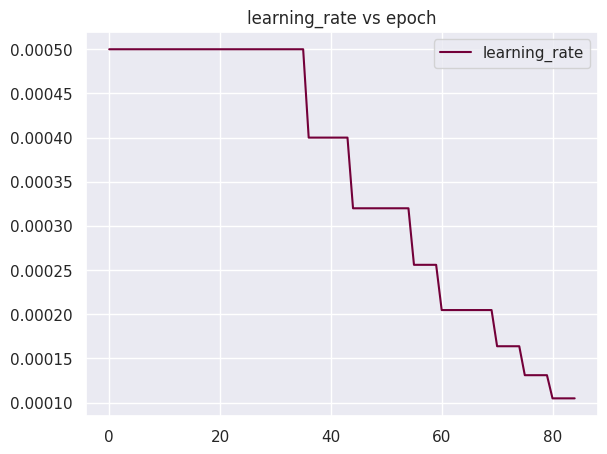

In [23]:
metric_plots[metrics_to_plot[0]][0]


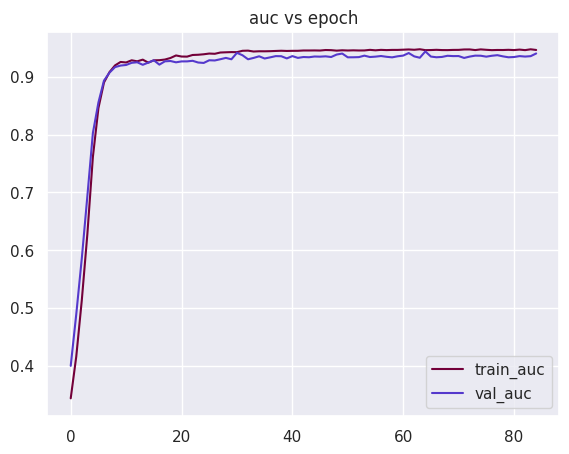

In [24]:
metric_plots[metrics_to_plot[1]][0]

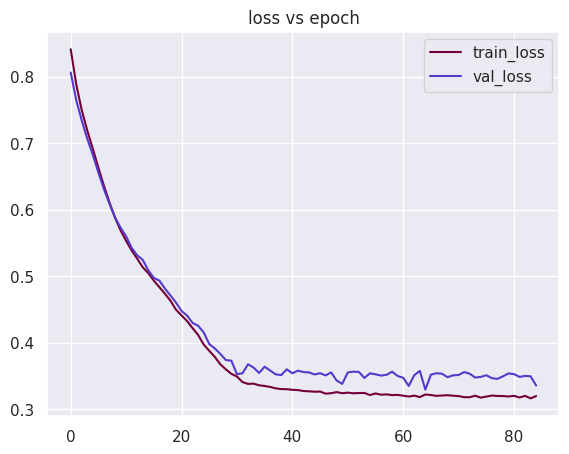

In [25]:
metric_plots[metrics_to_plot[2]][0]

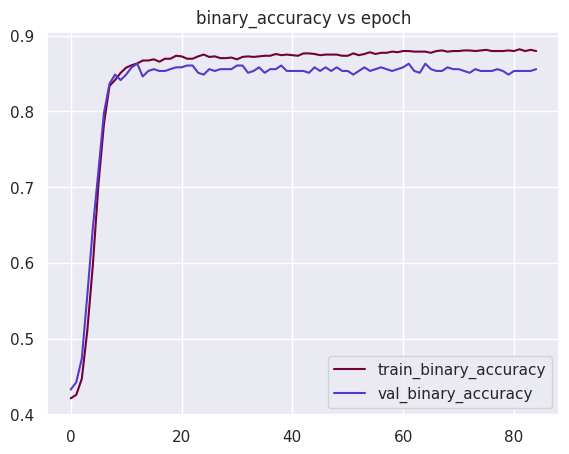

In [26]:
metric_plots[metrics_to_plot[3]][0]

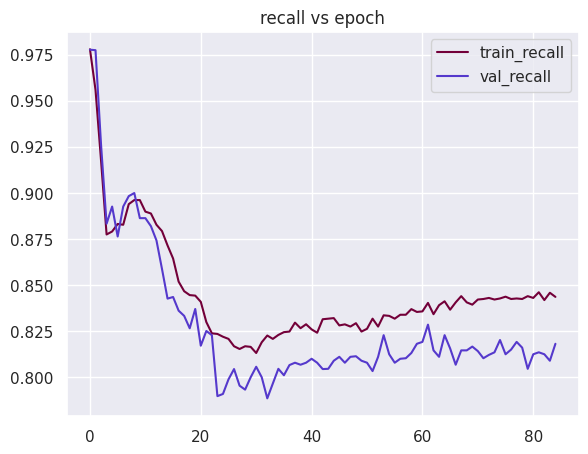

In [27]:
metric_plots[metrics_to_plot[4]][0]

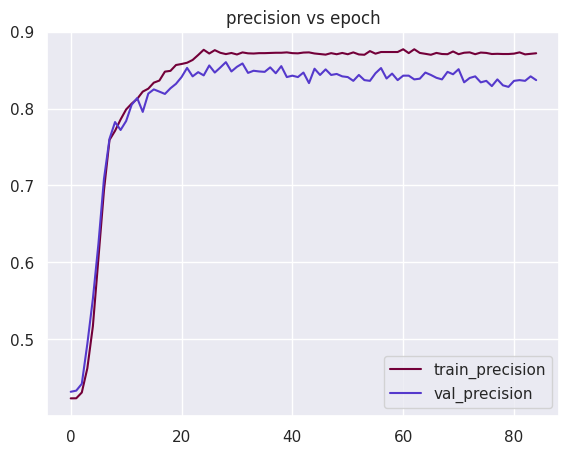

In [28]:
metric_plots[metrics_to_plot[5]][0]

In [29]:
# add plots as artifacts
with mlflow.start_run(run_id=run_id) as mlflow_run:
    for mm in metrics_to_plot:
        fig_path = os.path.join(plot_dir, f'{mm}_vs_epoch.png');
        mlflow.log_artifact(fig_path, artifact_path='training_plots')

🏃 View run delightful-vole-839 at: http://pistachio_mlflow:5000/#/experiments/312072479125166365/runs/49a04517232e4fa2918c4836778eadbf
🧪 View experiment at: http://pistachio_mlflow:5000/#/experiments/312072479125166365


In [30]:
## Model Evaluation


## mlflow tracking

In [31]:
# import mlflow

# mlflow.set_tracking_uri(uri="http://pistachio_mlflow:5000")

In [32]:
# history_df['epoch'] = history_df.index


In [33]:

# best_epoch = history_df.loc[history_df.val_loss == np.min(history_df.val_loss)]
# # best_epoch

# best_stats = best_epoch.to_dict(orient='records')[0]
# # best_stats
# mlflow.set_experiment('tf_pistachio_20241128')

# params = {
#     'BATCH_SIZE': BATCH_SIZE,
#     'PREFETCH': PREFETCH,
#     'SEED': SEED,
#     'UNITS': UNITS,
#     'EPOCHS': EPOCHS,
#     'LEARNING_RATE': LEARNING_RATE,
#     'LR_PLATEAU_FACTOR': LR_PLATEAU_FACTOR,
#     'LR_DECAY_RATE': LR_DECAY_RATE,
#     'MIN_LEARNING_RATE': MIN_LEARNING_RATE,
#     'FEATURE_COLUMNS': feature_columns
# }
    
# with mlflow.start_run():
#     mlflow.log_params(params)
#     for k,v in best_stats.items():
#         mlflow.log_metric(k,v)
#     mlflow.set_tag("Training Info", "initial - 2 layer dense, no regularisation, glorot initial")
    

In [34]:


def get_roc_results(predicted_probs: List[float], actual_classes: List[float]) -> Tuple[List[float],List[float],List[float]]:
    """get roc curve definition

    Args:
        predicted_probs (List[float]): predicted probabilities
        actual_classes (List[float]): actual binary labels

    Returns:
        Tuple[List,List,List]: fpr, tpr, thresholds
    """
    fpr, tpr, thresholds = roc_curve(actual_classes, predicted_probs)
    if thresholds[0] == float('inf'):
        thresholds[0] = sys.float_info.max

    return fpr, tpr, thresholds

#################################################################

def plot_roc_curve(fpr, tpr, thresholds, title: str="ROC curve", xlabel='False Positive Rate', ylabel: str='True Positive Rate') -> Tuple[mpl.figure.Figure, mpl.axes.Axes]:
    """_summary_

    Args:
        fpr (_type_): _description_
        tpr (_type_): _description_
        thresholds (_type_): _description_
        title (str, optional): _description_. Defaults to "ROC curve".
        xlabel (str, optional): _description_. Defaults to 'False Positive Rate'.
        ylabel (str, optional): _description_. Defaults to 'True Positive Rate'.

    Returns:
        Tuple[mpl.Figure, mpl.Axis]: _description_
    """
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    ax.plot(fpr, tpr, color=sns.xkcd_rgb['blurple'], label='roc curve')
    ax.plot([0.0, 1.0],[0.0, 1.0], color=sns.xkcd_rgb['merlot'], linestyle='--', label='random')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    # fig.show()
    return fig, ax
#################################################################

## custom training loop stuff

In [35]:
# %load_ext tensorboard

In [36]:
# %tensorboard --logdir ./pistachio_model_logs

# run tensorboard --logdir pistachio_model_logs --bind_all
# in terminal

In [37]:
# @tf.function
# def train_step(images, labels):
#   with tf.GradientTape() as tape:
#     # training=True is only needed if there are layers with different
#     # behavior during training versus inference (e.g. Dropout).
#     predictions = model(images, training=True)
#     loss = loss_object(labels, predictions)
#   gradients = tape.gradient(loss, model.trainable_variables)
#   optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#   train_loss(loss)
#   train_accuracy(labels, predictions)

In [38]:
# @tf.function
# def test_step(images, labels):
#   # training=False is only needed if there are layers with different
#   # behavior during training versus inference (e.g. Dropout).
#   predictions = model(images, training=False)
#   t_loss = loss_object(labels, predictions)

#   test_loss(t_loss)
#   test_accuracy(labels, predictions)

In [39]:

# for epoch in range(EPOCHS):
#   # Reset the metrics at the start of the next epoch
#   train_loss.reset_state()
#   train_accuracy.reset_state()
#   test_loss.reset_state()
#   test_accuracy.reset_state()

#   for images, labels in train_ds:
#     train_step(images, labels)

#   for test_images, test_labels in test_ds:
#     test_step(test_images, test_labels)

#   print(
#     f'Epoch {epoch + 1}, '
#     f'Loss: {train_loss.result():0.2f}, '
#     f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
#     f'Test Loss: {test_loss.result():0.2f}, '
#     f'Test Accuracy: {test_accuracy.result() * 100:0.2f}'
#   )